In [1]:
import numpy as np
import pandas as pd
import cbsodata
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
#toc = pd.DataFrame(cbsodata.get_table_list())
#toc

In [3]:
data = pd.DataFrame(cbsodata.get_data('70895ned'))
data.dropna(subset = ["Overledenen_1"], inplace=True)
df=data[data.Perioden.str.contains('week')]
df=df[df.Perioden.str.contains('1995 week 0')==False].reset_index(drop=True)
df.iloc[1377:1387]

,ID,Geslacht,LeeftijdOp31December,Perioden,Overledenen_1
1377,1403,Totaal mannen en vrouwen,Totaal leeftijd,2020 week 53 (4 dagen),2352.0
1378,1405,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 0 (3 dagen),1725.0
1379,1406,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 1,4118.0
1380,1407,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 2,3825.0
1381,1408,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 3,3823.0
1382,1409,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 4,3758.0
1383,1411,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 1,476.0
1384,1412,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 2,511.0
1385,1413,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 3,473.0
1386,1414,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 4,513.0


In [4]:
df_clean = df.drop(columns = ['ID'])
df_clean['to_first_week']=df_clean.Perioden.str.contains('dag') & df_clean.Perioden.str.contains('week 1')
df_clean['to_last_week']=df_clean.Perioden.str.contains('dag') & df_clean.Perioden.shift(-1).str.contains('week 0')
df_clean['partial_week']=df_clean.Perioden.str.contains('dag')
df_clean.loc[df_clean['to_first_week'] == True, 'deaths'] = df_clean['Overledenen_1'].shift(+1) + df_clean['Overledenen_1'] 
df_clean.loc[df_clean['to_last_week'] == True, 'deaths'] = df_clean['Overledenen_1'].shift(-1) + df_clean['Overledenen_1'] 
df_clean.loc[df_clean['partial_week'] == False, 'deaths'] = df_clean['Overledenen_1']
df_clean = df_clean.dropna(subset = ["deaths"]).reset_index(drop=True)
df_clean[['year','week']] = df_clean.Perioden.str.split("week",expand=True)
df_clean['week'] = df_clean.week.str.extract('(\d+)')
df_clean['year'] = df_clean.year.str.extract('(\d+)')
df_clean = df_clean.drop(columns = ['Overledenen_1','to_first_week','to_last_week','partial_week'])
df_clean = df_clean.rename(columns={"LeeftijdOp31December": "age", "Geslacht": "gender"})
df_clean = df_clean[['Perioden','gender','age','year','week','deaths']]
df_clean['covid_year']=df_clean['year'] >= '2020'
df_clean.loc[df_clean['covid_year'] == False, 'covid_year'] = '1995-2019 +/- SD'
df_clean.loc[df_clean['covid_year'] == True, 'covid_year'] = df_clean['year']

df_clean.iloc[1355:1365]

,Perioden,gender,age,year,week,deaths,covid_year
1355,2020 week 52,Totaal mannen en vrouwen,Totaal leeftijd,2020,52,3849.0,2020
1356,2020 week 53 (4 dagen),Totaal mannen en vrouwen,Totaal leeftijd,2020,53,4077.0,2020
1357,2021 week 1,Totaal mannen en vrouwen,Totaal leeftijd,2021,1,4118.0,2021
1358,2021 week 2,Totaal mannen en vrouwen,Totaal leeftijd,2021,2,3825.0,2021
1359,2021 week 3,Totaal mannen en vrouwen,Totaal leeftijd,2021,3,3823.0,2021
1360,2021 week 4,Totaal mannen en vrouwen,Totaal leeftijd,2021,4,3758.0,2021
1361,1995 week 1,Totaal mannen en vrouwen,0 tot 65 jaar,1995,1,476.0,1995-2019 +/- SD
1362,1995 week 2,Totaal mannen en vrouwen,0 tot 65 jaar,1995,2,511.0,1995-2019 +/- SD
1363,1995 week 3,Totaal mannen en vrouwen,0 tot 65 jaar,1995,3,473.0,1995-2019 +/- SD
1364,1995 week 4,Totaal mannen en vrouwen,0 tot 65 jaar,1995,4,513.0,1995-2019 +/- SD


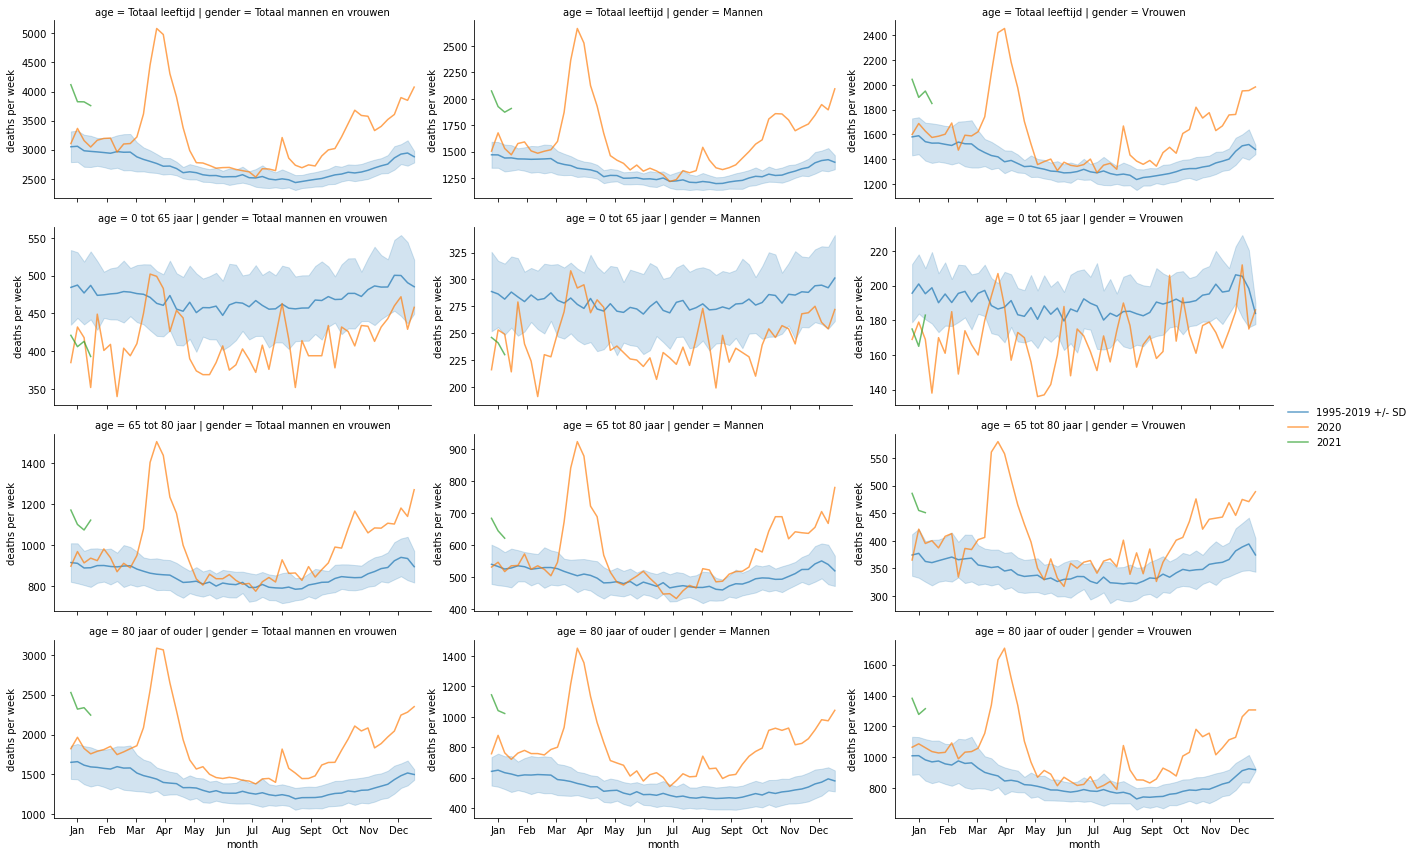

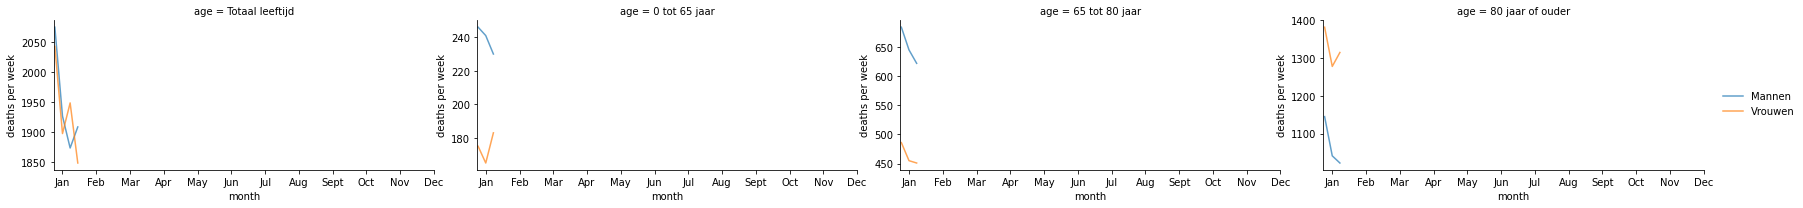

In [5]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

g = sns.FacetGrid(df_clean, col="gender", hue="covid_year", row='age', aspect=2,sharey=False)
g.map(sns.lineplot, 'week', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="month", ylabel = "deaths per week", xticks=np.arange(1, 53,(53/12) ), xticklabels=months)
g.add_legend(title = '')
g.savefig('naar_Geslacht_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

g = sns.FacetGrid(df_clean.query("year == '2021' & gender !='Totaal mannen en vrouwen'"), col="age", hue="gender", aspect=2,sharey=False)
g.map(sns.lineplot, 'week', 'deaths', alpha=.7)
g.set(xlabel="month", ylabel = "deaths per week", xticks=np.arange(1, 53,(53/12) ), xticklabels=months)
g.add_legend(title = '')
g.savefig('2021_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

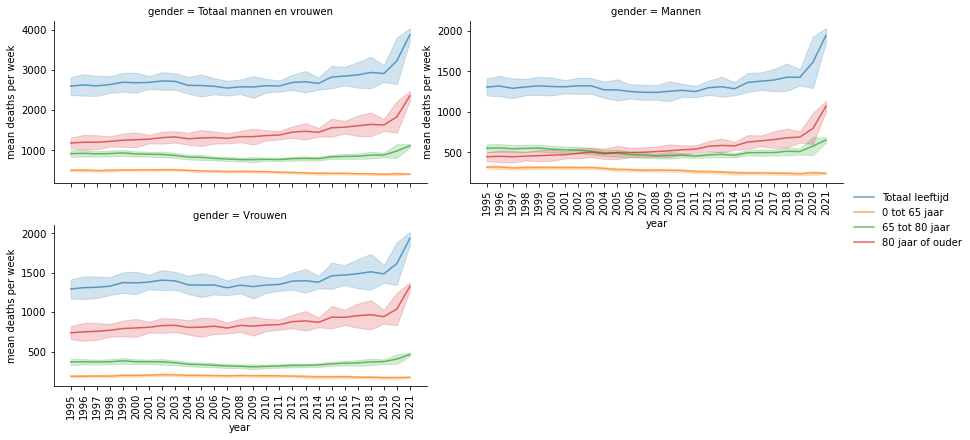

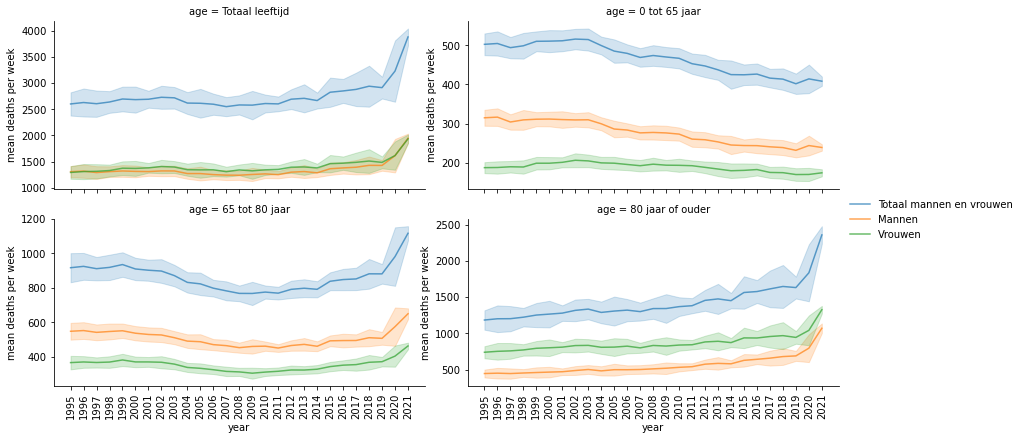

In [6]:
g = sns.FacetGrid(df_clean, col="gender", hue="age", col_wrap=2, aspect=2,sharey=False)
g.map(sns.lineplot, 'year', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="year", ylabel = "mean deaths per week")
g.set_xticklabels(rotation=90)
g.add_legend(title = '')
g.savefig('perjaar_Geslacht.png', dpi=300, bbox_inches='tight', facecolor='white')

g = sns.FacetGrid(df_clean, col="age", hue="gender",col_wrap=2, aspect=2,sharey=False)
g.map(sns.lineplot, 'year', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="year", ylabel = "mean deaths per week")
g.set_xticklabels(rotation=90)
g.add_legend(title = '')
g.savefig('perjaar_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

In [7]:
leeftijd='Totaal leeftijd'
#leeftijd='0 tot 65 jaar'
#leeftijd='65 tot 80 jaar'
#leeftijd='80 jaar of ouder'
sex='Totaal mannen en vrouwen'
#sex='Mannen'
#sex='Vrouwen'

df_circle=df_clean[(df_clean.age == leeftijd) & (df_clean.gender == sex)]
df_circle = df_circle.groupby('Perioden').sum().squeeze()
df_circle

Perioden
1995 week 1     2719.0
1995 week 10    2770.0
1995 week 11    2800.0
1995 week 12    2786.0
1995 week 13    2634.0
                 ...  
2020 week 9     3098.0
2021 week 1     4118.0
2021 week 2     3825.0
2021 week 3     3823.0
2021 week 4     3758.0
Name: deaths, Length: 1361, dtype: float64

In [13]:
deaths_per_year = pd.DataFrame(columns=range(1995, 2021+1), index=pd.RangeIndex(1, 53+1, name='week'))

for Perioden, deaths in df_circle.iteritems():
    year = int(Perioden[0:4])
    week = int(Perioden[9:12])
    deaths_per_year.loc[week, year] = deaths
    
deaths_per_year

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004
week,,,,,,,,,,,,,,,,,,,,,
1,2871.0,2746.0,2802.0,2949.0,3094.0,2767.0,2917.0,2930.0,2947.0,2766.0,...,2719.0,3546.0,3126.0,2675.0,3106.0,3564.0,3051.0,2946.0,3011.0,3333.0
2,2808.0,2834.0,2837.0,3045.0,3215.0,2830.0,2819.0,2773.0,3038.0,2819.0,...,2823.0,3257.0,3290.0,2558.0,3005.0,3438.0,2852.0,3145.0,2987.0,3333.0
3,2845.0,2770.0,2694.0,2928.0,3408.0,2846.0,2624.0,2785.0,3011.0,2740.0,...,2609.0,2970.0,3249.0,2418.0,2918.0,3307.0,2907.0,3032.0,2981.0,3055.0
4,2813.0,2747.0,2680.0,2773.0,3218.0,2865.0,2620.0,2789.0,3082.0,2710.0,...,2664.0,2855.0,3185.0,2530.0,2866.0,3203.0,3031.0,3079.0,2963.0,2921.0
5,2906.0,2838.0,2717.0,2733.0,3161.0,2858.0,2728.0,2815.0,3192.0,2708.0,...,2577.0,2992.0,3061.0,2691.0,2972.0,2967.0,2928.0,2938.0,2821.0,2907.0
6,3001.0,2819.0,2718.0,2676.0,3165.0,2831.0,2675.0,3034.0,3143.0,2855.0,...,2536.0,3089.0,3012.0,2615.0,3105.0,2835.0,2861.0,2859.0,2745.0,2751.0
7,3094.0,2841.0,2716.0,2703.0,2877.0,2900.0,2621.0,3089.0,3033.0,2796.0,...,2551.0,3046.0,2980.0,2695.0,3123.0,2773.0,2761.0,2778.0,2736.0,2692.0
8,3197.0,2856.0,2706.0,2821.0,2854.0,2929.0,2651.0,3035.0,3211.0,2753.0,...,2510.0,2887.0,2807.0,2719.0,3134.0,2869.0,2685.0,2957.0,2923.0,2746.0
9,3351.0,2880.0,2829.0,2775.0,2713.0,2757.0,2686.0,3061.0,3170.0,2713.0,...,2490.0,2878.0,2792.0,2627.0,3241.0,2673.0,2749.0,3231.0,3021.0,2722.0


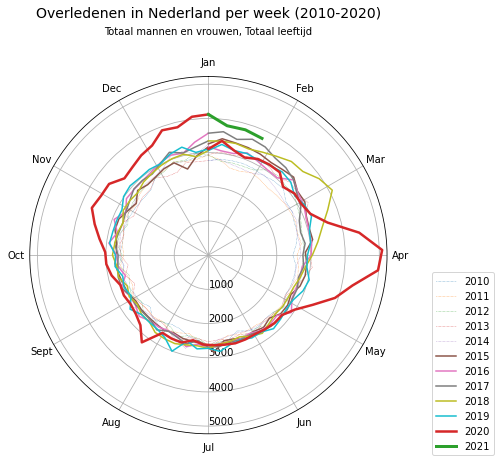

In [9]:
def data_for_year(y):
    year = deaths_per_year[y].dropna().to_numpy()
    if y == 2021:
        num_weeks = len(year)
        day_of_the_year = num_weeks*7 - 3 # ex. week 46 -> november 15 -> day 319
        theta = np.linspace(0, (day_of_the_year/365)*2*np.pi, num_weeks)
    else:
        # append first week of next year for correct radial plotting
        year = np.append(year, deaths_per_year.loc[1, y+1])
        theta = np.linspace(0, 2*np.pi, len(year))
    return (theta, year)

def plot_year(ax, y, **kwargs):
    ax.plot(*data_for_year(y), label=f"{y}", **kwargs)

def setup_polar_plot(figsize=(8, 6), constrained_layout=True):
    fig = plt.figure(figsize=figsize, constrained_layout=constrained_layout)
    ax = fig.add_subplot(111, projection='polar')

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(np.arange(0, 2*np.pi, np.pi/6))
    ax.set_xticklabels(months)

    ax.set_rlabel_position(180)
#    ax.set_yticklabels(['1000', '2000', '3000', '4000', '5000', ''])

    return fig, ax

fig, ax = setup_polar_plot()
plot_year(ax, 2010, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2011, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2012, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2013, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2014, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2015, linewidth=1.5)
plot_year(ax, 2016, linewidth=1.5)
plot_year(ax, 2017, linewidth=1.5)
plot_year(ax, 2018, linewidth=1.5)
plot_year(ax, 2019, linewidth=1.5)
plot_year(ax, 2020, color='tab:red', linewidth=2.5)
plot_year(ax, 2021, color='tab:green', linewidth=3)

#plot_year(ax, 2011, color='tab:gray', linewidth=0.5)
#plot_year(ax, 2012, color='tab:gray', linestyle='dotted')
#plot_year(ax, 2013, color='tab:gray', linestyle='dashed')
#plot_year(ax, 2014, color='tab:gray', linestyle='dashdot')
#plot_year(ax, 2015, color='tab:gray')
#plot_year(ax, 2016, color='tab:blue', linestyle='dashdot')
#plot_year(ax, 2017, color='tab:blue')
#plot_year(ax, 2018, color='tab:green')
#plot_year(ax, 2019, color='tab:orange')
#plot_year(ax, 2020, color='tab:red', linewidth=3)

#ax.set_rmax(5500)
fig.legend(loc='lower right')
fig.suptitle("Overledenen in Nederland per week (2010-2020)", fontsize=14, y=1.04)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)

plt.savefig('sterfte_perjaar.png', dpi=300, bbox_inches='tight', facecolor='white')

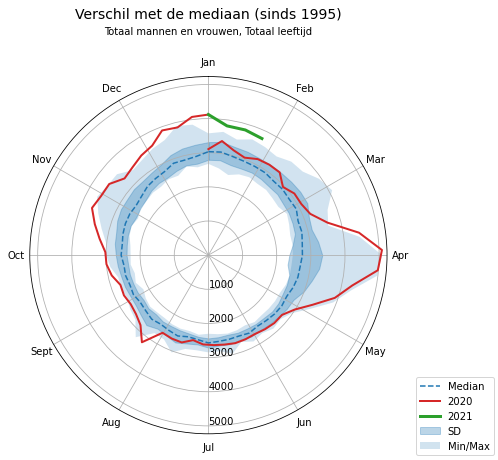

In [10]:
years = deaths_per_year.iloc[:, :-1] # excluding 2020 and 2021

mean = years.mean(skipna=True,axis=1)
mean[53] = mean[1]

median = years.median(skipna=True,axis=1)
median[53] = median[1]

min = years.min(axis=1)
min[53] = min[1]

max = years.max(axis=1)
max[53] = max[1]

sd = years.std(axis=1)
sd[53] = sd[1]

q25 = deaths_per_year.astype(float).quantile(0.25, axis=1)
q25[53] = q25[1]

q75 = deaths_per_year.astype(float).quantile(0.75, axis=1)
q75[53] = q75[1]

fig, ax = setup_polar_plot()

# ax.plot(np.linspace(0, 2*np.pi, len(mean)), mean, label="5y mean")
# ax.plot(np.linspace(0, 2*np.pi, len(data_for_year(2019))), data_for_year(2019), label="2019")
ax.fill_between(np.linspace(0, 2*np.pi, len(min)), mean+sd, mean-sd, alpha=0.3, label="SD", color='tab:blue')

ax.fill_between(np.linspace(0, 2*np.pi, len(min)), min, max, alpha=0.2, label="Min/Max")
#ax.fill_between(np.linspace(0, 2*np.pi, len(q25)), q25, q75, alpha=0.3, label="50%", color='tab:green')

ax.plot(np.linspace(0, 2*np.pi, len(median)), median, label="Median", linestyle='dashed')
plot_year(ax, 2020, color='tab:red', linewidth=2)
plot_year(ax, 2021, color='tab:green', linewidth=3)


#ax.set_rmax(5500)
fig.legend(loc='lower right')
fig.suptitle(f"Verschil met de mediaan (sinds 1995)", fontsize=14, y=1.04)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)

plt.savefig('sterfte_median.png', dpi=300, bbox_inches='tight', facecolor='white')

done


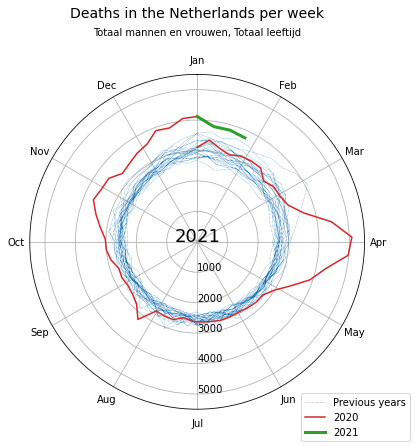

In [11]:
start_year = 1995

fig, ax = setup_polar_plot(figsize=(6, 6.2), constrained_layout=False)

# english month labels
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# nudge ax position
pos = ax.get_position()
pos.y0 -= 0.05
pos.y1 -= 0.05
pos.x0 -= 0.012
pos.x1 -= 0.012
ax.set_position(pos)

fig.suptitle("Deaths in the Netherlands per week", fontsize=14)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)


old, = ax.plot([], [], color='tab:blue', linewidth=0.5, linestyle='dotted', label="Previous years")
prev, = ax.plot([], [], color='tab:red', label="2020")
current, = ax.plot([], [], color='tab:green', linewidth=3, label="2021")
center = ax.text(0, 25, "5000", horizontalalignment='center', fontsize=18)
ax.set_rmax(5500)

def year_and_week_for_index(i):
    y = start_year
    while True:
        len_year = len(deaths_per_year[y].dropna()) + 1
        if len_year > i:
            return (y, i+1)
        else:
            y += 1
            i -= (len_year-1)

def data_for_index(i):
    y, w = year_and_week_for_index(i)
    #print(y, w)
    theta, year = data_for_year(y)
    return theta[:w], year[:w]

def init():
    old.set_data([], []) 
    prev.set_data([], []) 
    current.set_data([], []) 
    center.set_text("")
    return old, prev, current, center

def animate(i):
    y = year_and_week_for_index(i)[0]

    if y > start_year:
        old_theta = np.array([])
        old_data = np.array([])
        for year in range(start_year, y-1):
            theta, data = data_for_year(year)
            old_theta = np.append(old_theta, theta)
            old_data = np.append(old_data, data)
        old.set_data(old_theta, old_data)
        prev.set_data(*data_for_year(y-1))

    current.set_data(*data_for_index(i))
    center.set_text(f"{y}")
    return old, prev, current, center

num_frames = len(df_circle)

anim = mpl.animation.FuncAnimation(fig, animate, init_func=init, frames=num_frames, interval=50, blit=True) 
anim.save('sterfte_anim.mp4', writer='ffmpeg', dpi=300, extra_args=['-vf', 'tpad=stop_mode=clone:stop_duration=5'])
#anim.save(f"img/{sex}_{leeftijd}_anim.gif", writer='imagemagick', dpi=72, fps=30, savefig_kwargs={'facecolor': 'white'})

fig.legend(loc='lower right')
plt.savefig('sterfte_anim.png', dpi=300, bbox_inches='tight', facecolor='white')
print("done")

In [12]:
import ffmpeg
(
    ffmpeg
    .input('sterfte_anim.mp4')
    .output('sterfte_anim.gif')
    .run(overwrite_output=True)
)

(None, None)